In [1]:
import numpy as np
import xarray as xr
import json
import os
import socket
import matplotlib.pyplot as plt

import xmitgcm as xm

from utils_mitgcm import open_mitgcm_ds_from_config

import eddytools as et

In [2]:
model = 'geneva_200m'

In [3]:
mitgcm_config, ds_to_plot = open_mitgcm_ds_from_config('config.json', model)

In [4]:
str_start_time = "2023-07-03T00:00:00.000000000"
str_end_time = "2023-07-03T04:00:00.000000000"

outputpath = "./workspace/nencioli/"

In [5]:
# load data
data = ds_to_plot

In [6]:
start_date_analysis = np.datetime64(str_start_time)
end_date_analysis = np.datetime64(str_end_time)

data_cropped = data.sel(time=slice(start_date_analysis, end_date_analysis))
data_cropped = data_cropped.isel(Z=0)

In [7]:
temp_ini = data_cropped.THETA.isel(time=0)
mask = temp_ini.where(abs(temp_ini) > 1e-10).values

In [8]:
VVEL_new = (
    data_cropped["VVEL"]
    .rename({"YG": "lat", "XC": "lon", "Z": "Depth"})
    .assign_coords(lat=data_cropped["YC"].values)
)
UVEL_new = (
    data_cropped["UVEL"]
    .rename({"XG": "lon", "YC": "lat", "Z": "Depth"})
    .assign_coords(lon=data_cropped["XC"].values)
)

data_aligned = xr.Dataset(
    {
        "UVEL": mask*UVEL_new,
        "VVEL": mask*VVEL_new,
    },
    coords={
        "lon": data_cropped["XC"].values,
        "lat": data_cropped["YC"].values,
        "Depth": data_cropped["Z"].values,
    },
)

data_aligned["SPEED"] = np.sqrt(data_aligned["UVEL"] ** 2 + data_aligned["VVEL"] ** 2)

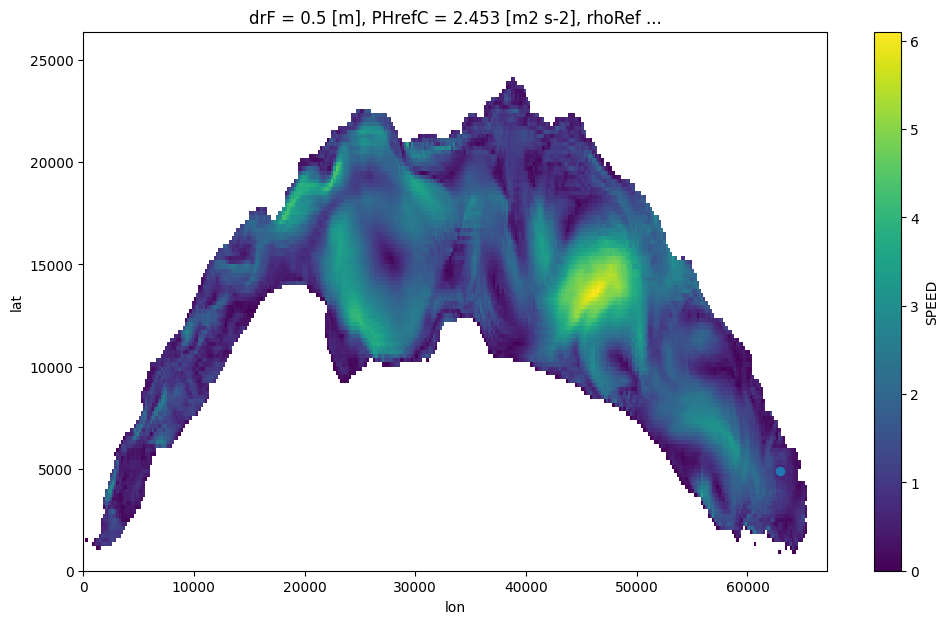

In [9]:
plt.figure(figsize=(12,7))
data_aligned["SPEED"].isel(time=0).plot()
plt.scatter(data_aligned.lon.values[314],data_aligned.lat.values[24])

In [10]:
data_aligned.lon.values.max()

np.float64(67100.0)

In [11]:
# Specify parameters for eddy detection
detection_parameters = {
    "model": "MITgcm",
    "grid": "cartesian",
    "hemi": "north",
    "start_time": str_start_time,  # time range start
    "end_time": str_end_time,  # time range end
    "calendar": "standard",  # calendar, must be either 360_day or standard
    "lon1": data_aligned.lon.values.min(),  # minimum longitude of detection region
    "lon2": data_aligned.lon.values.max(),  # maximum longitude
    "lat1": data_aligned.lat.values.min(),  # minimum latitude
    "lat2": data_aligned.lat.values.max(),  # maximum latitude
    "res": 0.2,  # resolution of the fields in km
    "min_dep": 1,  # minimum ocean depth where to look for eddies in m
    "no_long": False,  # If True, elongated shapes will not be considered
    "no_two": False,  # If True, eddies with two minima in the OW
    # parameter and a OW > OW_thr in between  will not
    # be considered
    "a": 5, # u/v increase "a" points away from reversal
    "b": 5, # find the velocity minimum within the searching area defined by
            # "b" around the points that satisfy the first two constraints
    "rad": 2,
}

In [12]:
et.detection.detect_UV(data_aligned, detection_parameters, "UVEL", "VVEL", "SPEED", use_bags=True)

preparing data for eddy detection (masking and region extracting etc.)
Detecting eddies in velocity fields
detect_UV_core
The rotation is pretty uniform, no weird thing happening there. Looking for eddy boundaries...
Local minima found in indices ([21],[290]). time=4
[array([[57300.,  4500.],
       [57300.,  4500.],
       [57300.,  4500.],
       [57300.,  4500.],
       [57300.,  4500.]])]
lenght iso: 155
xx Contour is not closed.
xx Contour is not closed.
xx Contour is not closed.
xx Contour is not closed.
xx Contour is not closed.
xx Contour is not closed.
xx Contour is not closed.
xx Contour is not closed.
Error: QH6421 qhull internal error (qh_maxsimplex): qh.MAXwidth required for qh_maxsimplex.  Used to estimate determinate

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 723431539  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  0  Error-roundoff 4e-11  _one-merge 2e-10  _near-inside 1e-09
  Visible-distance 8.1e-11  U-m

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.

Traceback
---------
  File "/home/leroquan@eawag.wroot.emp-eaw.ch/eddytools/eddytools_env/lib/python3.12/site-packages/dask/local.py", line 229, in execute_task
    result = task(data)
             ^^^^^^^^^^
  File "/home/leroquan@eawag.wroot.emp-eaw.ch/eddytools/eddytools_env/lib/python3.12/site-packages/dask/_task_spec.py", line 745, in __call__
    return self.func(*new_argspec)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leroquan@eawag.wroot.emp-eaw.ch/eddytools/eddytools_env/lib/python3.12/site-packages/dask/_task_spec.py", line 171, in _execute_subgraph
    res = execute_graph(final, keys=[outkey])
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leroquan@eawag.wroot.emp-eaw.ch/eddytools/eddytools_env/lib/python3.12/site-packages/dask/_task_spec.py", line 984, in execute_graph
    cache[key] = node(cache)
                 ^^^^^^^^^^^
  File "/home/leroquan@eawag.wroot.emp-eaw.ch/eddytools/eddytools_env/lib/python3.12/site-packages/dask/_task_spec.py", line 745, in __call__
    return self.func(*new_argspec)
           ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leroquan@eawag.wroot.emp-eaw.ch/eddytools/eddytools_env/lib/python3.12/site-packages/dask/bag/core.py", line 1880, in reify
    seq = list(seq)
          ^^^^^^^^^
  File "/home/leroquan@eawag.wroot.emp-eaw.ch/eddytools/eddytools_env/lib/python3.12/site-packages/dask/bag/core.py", line 2068, in __next__
    return self.f(*vals)
           ^^^^^^^^^^^^^
  File "/home/leroquan@eawag.wroot.emp-eaw.ch/eddytools/eddytools/detection.py", line 1573, in <lambda>
    lambda tt: detect_UV_core(data, det_param.copy(), U, V, SPEED, tt,
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leroquan@eawag.wroot.emp-eaw.ch/eddytools/eddytools/detection.py", line 1059, in detect_UV_core
    eddy_i, eddy_j, eddy_mask = get_eddy_indeces(lon_large, lat_large,
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leroquan@eawag.wroot.emp-eaw.ch/eddytools/eddytools/detection.py", line 412, in get_eddy_indeces
    in_out_vel = interpolate_limits(pts_I[iii], pts_J[iii],
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leroquan@eawag.wroot.emp-eaw.ch/eddytools/eddytools/detection.py", line 297, in interpolate_limits
    svel = vel[int(np.max([d_j-n, 1])):int(np.min([d_j+n, np.shape(vel)[0]])),
                   ^^^^^^^^^^^^^^^^^^
  File "/home/leroquan@eawag.wroot.emp-eaw.ch/eddytools/eddytools_env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py", line 3164, in max
    return _wrapreduction(a, np.maximum, 'max', axis, None, out,
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/leroquan@eawag.wroot.emp-eaw.ch/eddytools/eddytools_env/lib/python3.12/site-packages/numpy/_core/fromnumeric.py", line 86, in _wrapreduction
    return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


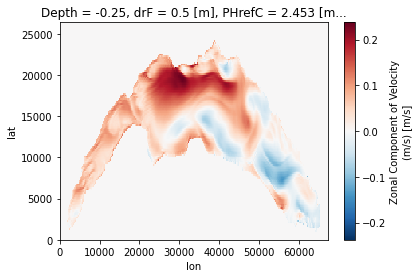

In [10]:
data_aligned["UVEL"].isel(time=-1, Depth=0).plot()

In [12]:
t = 0
i1 = 24
i2 = 314
rad = 2
a = 5

In [13]:
u = data_aligned.UVEL.isel(time=t).values
v = data_aligned.VVEL.isel(time=t).values
speed = data_aligned.SPEED.isel(time=t).values
e1f = data_aligned['dxC'].values
e2f = data_aligned['dyC'].values

In [14]:
lon, lat = np.meshgrid(data_aligned.lon.sel(lon=slice(data_aligned.lon.values.min(),
                                              data_aligned.lon.values.max())).values,
                       data_aligned.lat.sel(lat=slice(data_aligned.lat.values.min(),
                                              data_aligned.lat.values.max())).values)

In [15]:
bounds = np.shape(speed)

In [16]:
u_large = u[int(max(i1-(rad*a), 1)):int(min(i1+(rad*a), bounds[0])),
            int(max(i2-(rad*a), 1)):int(min(i2+(rad*a), bounds[1]))]
v_large = v[int(max(i1-(rad*a), 1)):int(min(i1+(rad*a), bounds[0])),
            int(max(i2-(rad*a), 1)):int(min(i2+(rad*a), bounds[1]))]
speed_large = speed[int(max(i1-(rad*a), 1)):int(min(i1+(rad*a), bounds[0])),
                    int(max(i2-(rad*a), 1)):int(min(i2+(rad*a), bounds[1]))]
lon_large = lon[int(max(i1-(rad*a), 1)):int(min(i1+(rad*a), bounds[0])),
                int(max(i2-(rad*a), 1)):int(min(i2+(rad*a), bounds[1]))]
lat_large = lat[int(max(i1-(rad*a), 1)):int(min(i1+(rad*a), bounds[0])),
                int(max(i2-(rad*a), 1)):int(min(i2+(rad*a), bounds[1]))]
e1f_large = e1f[int(max(i1-(rad*a), 1)):int(min(i1+(rad*a), bounds[0])),
                int(max(i2-(rad*a), 1)):int(min(i2+(rad*a), bounds[1]))]
e2f_large = e2f[int(max(i1-(rad*a), 1)):int(min(i1+(rad*a), bounds[0])),
                int(max(i2-(rad*a), 1)):int(min(i2+(rad*a), bounds[1]))]

In [17]:
u_psi = u_large
v_psi = v_large
dx = e1f_large
dy = e2f_large
vel = speed_large

In [18]:
lx = np.shape(u_psi)[0]
ly = np.shape(u_psi)[1]
# itegrate first row of v along longitude (first term of eq.A2)
cx = np.nancumsum(v_psi[0, :]) * dx[0, :]
# integrate first column of u along latitude (second term of eq.A3)
cy = np.nancumsum(u_psi[:, 0]) * dy[:, 0]
# compute streamfunction
# PSI from integrating v firts and then u
psi_xy = (-cx[None, :] + np.nancumsum(u_psi, axis=0) * dy)
# PSI from integrating u first and then v
psi_yx = (-np.nancumsum(v_psi, axis=1) * dx + cy[:, None])
# final PSI as average between the two
psi= (psi_xy + psi_yx) / 2

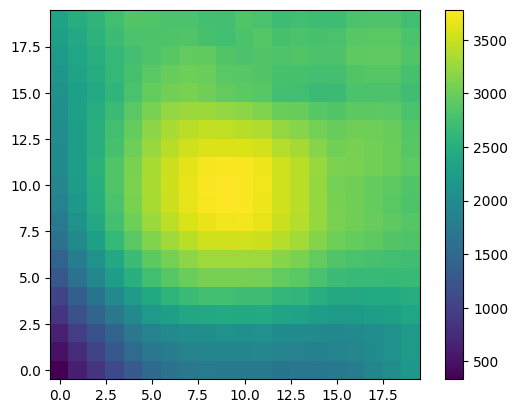

In [19]:
plt.imshow(psi)
plt.gca().invert_yaxis()
plt.colorbar()

In [20]:
from contourpy import contour_generator

In [30]:
(c_j, c_i) = np.where((lat==ec_lat) & (lon==ec_lon))
dkm = 0.05 * (lon[c_j, 1] - lon[c_j, 0])

In [21]:
cg = contour_generator(lon_large, lat_large, psi)

In [22]:
C = [cg.lines(np.linspace(np.nanmin(psi), np.nanmax(psi), 100)[i]) for i in np.arange(100)]

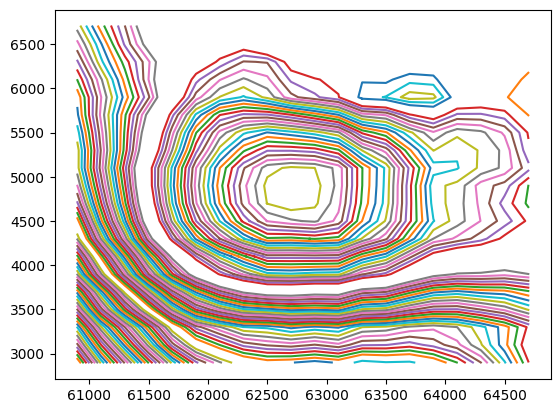

In [23]:
for i in range(len(C)-1):
    plt.plot(C[i][0][:,0],C[i][0][:,1])

In [23]:
from matplotlib.path import Path
from scipy.spatial import ConvexHull

In [24]:
def inpolygon(point_i, point_j, x, y):
    p = np.array([x, y]).T
    hullp = ConvexHull(p)
    poly_path = Path(p[hullp.vertices])
    return poly_path.contains_point([point_i, point_j])

In [25]:
ec_lon = lon[i1,i2]
ec_lat = lat[i1,i2]

In [26]:
# intialize the two variables
eddy_lim = []
largest_curve=[]
# rearrange all the contours in C to the structure array 'isolines'
# each element of isolines contains all the vertices of a given contour
# level of PSI
isolines = {}
isolines_max = []
i = 0
ii = 0
there_are_contours = True
while there_are_contours:
    for j in np.arange(len(C[ii])):
        isolines[i] = {}
        isolines[i]["x"] = []
        isolines[i]["y"] = []
        isolines[i]["x"] = list(C[ii][j][:, 0])
        isolines[i]["y"] = list(C[ii][j][:, 1])
        isolines_max.append(np.nanmax(isolines[i]["y"]))
        i += 1
    ii += 1
    try:
        test = C[ii]
        there_are_contours = True
    except:
        there_are_contours = False
# sort the contours accroding to their maximum latitude; this way the first
# closed contour across which velocity increases will also be the largest
# one (it's the one which extend further north).
sorted_iso = np.argsort(isolines_max)[::-1]
print(f"lenght iso: {len(sorted_iso)}")

lenght iso: 124


In [27]:
from scipy import interpolate

In [32]:
lon, lat, ec_lon, ec_lat, psi, vel = lon_large, lat_large, slon[X, Y][0], slat[X, Y][0], psi, speed_large

(c_j, c_i) = np.where((lat==ec_lat) & (lon==ec_lon))
dkm = 0.05 * (lon[c_j, 1] - lon[c_j, 0])
# compute contourlines of the streamfunction field (100 contours)
cg = contour_generator(lon, lat, psi)
C = [cg.lines(np.linspace(np.nanmin(psi), np.nanmax(psi), 100)[i]) for i in np.arange(100)]

# intialize the two variables
eddy_lim = []
largest_curve=[]
# rearrange all the contours in C to the structure array 'isolines'
# each element of isolines contains all the vertices of a given contour
# level of PSI
isolines = {}
isolines_max = []
i = 0
ii = 0
there_are_contours = True
while there_are_contours:
    for j in np.arange(len(C[ii])):
        isolines[i] = {}
        isolines[i]["x"] = []
        isolines[i]["y"] = []
        isolines[i]["x"] = list(C[ii][j][:, 0])
        isolines[i]["y"] = list(C[ii][j][:, 1])
        isolines_max.append(np.nanmax(isolines[i]["y"]))
        i += 1
    ii += 1
    try:
        test = C[ii]
        there_are_contours = True
    except:
        there_are_contours = False
# sort the contours accroding to their maximum latitude; this way the first
# closed contour across which velocity increases will also be the largest
# one (it's the one which extend further north).
sorted_iso = np.argsort(isolines_max)[::-1]
print(f"lenght iso: {len(sorted_iso)}")

# restart the counter and initialize the two flags
i = 0
closed_indx = 0 # set to 1 when eddy shape is found
largest_indx = 0 # set to 1 when largest closed contour is found
# inspect all isolines until the eddy shape is determined
# (closed_indx=1 stops the loop)
while ((closed_indx == 0) & (i < len(isolines))):
    ii = sorted_iso[i]
    xdata = isolines[ii]["x"] # vertex lon's
    ydata = isolines[ii]["y"] # vertex lat's
    # conditions to have the largest closed contour around the center
    # (isolines already sorted by maximum latitude)
    # 1) closed contours
    # 2) detected eddy center inside the polygon
    if ((len(xdata) < 3) | (len(ydata) < 3)):
        print('xx Contour is not closed.')
        i += 1
        continue
    try:
        inpo = inpolygon(ec_lon, ec_lat, xdata, ydata)
    except Exception as e:
        print(f'Error: {e}')
        inpo = False
    if (((xdata[0] == xdata[-1]) & (ydata[0] == ydata[-1])) & inpo):
        print('Contour is closed.')
        # find the contour extremes
        Nj = np.max(ydata)
        Ni = np.max(xdata[int(np.where(ydata==Nj)[0][0])])
        Sj = np.min(ydata)
        Si = np.min(xdata[int(np.where(ydata==Sj)[0][0])])
        Ei = np.max(xdata)
        Ej = np.min(ydata[int(np.where(xdata==Ei)[0][0])])
        Wi = np.min(xdata)
        Wj = np.max(ydata[int(np.where(xdata==Wi)[0][0])])
        # check if velocity across the contour increases
        direct = ['N', 'S', 'E', 'W']
        pts_I = [Ni, Si, Ei, Wi]
        pts_J = [Nj, Sj, Ej, Wj]
        # inspect one extreme at the time (faster)
        iii = 0 # counter
        smaller_vel = 0  # flag to stop the loop (1 if velocity decreases
                         # across the fourth extremes)
        smaller_vel1 = 0 # flag to stop the loop (1 if velocity decreases
                         # across the third extremes)
        smaller_vel2 = 0 # flag to stop the loop (1 if velocity decreases
                         # across the second extremes)
        smaller_vel3 = 0 # flag to stop the loop (1 if velocity decreases
                         # across the first extremes)
        while ((iii < len(direct)) & (smaller_vel == 0)):
            # interpolate velocity across the extreme
            in_out_vel = interpolate_limits(pts_I[iii], pts_J[iii],
                                            lon, lat, dkm, vel, direct[iii])
            # change the flag value if velocity decreases
            if (in_out_vel[0] > in_out_vel[1]):
                if (smaller_vel3 == 0):
                    smaller_vel3 = 1
                elif (smaller_vel2 == 0):
                    smaller_vel2 = 1
                elif (smaller_vel1 == 0):
                    smaller_vel1 = 1
                elif (smaller_vel == 0):
                    smaller_vel = 1
            iii += 1 # increase the counter
        # only if velocity increases across all four extremes the closed
        # contour is saved as eddy shape
        if (smaller_vel == 0):
            eddy_lim = [xdata, ydata]
            closed_indx = 1
        # largest closed conotur is saved as well
        if (largest_indx == 0):
            largest_curve = [xdata, ydata]
            largest_indx = 1
    i += 1 # increase the counter
# in case velocity doesn't increase across the closed contour, eddy shape
# is defined simply as the largest closed contour
if ((eddy_lim==[]) & (largest_curve!=[])):
    print('Largest closed contour selected')
    eddy_lim = largest_curve
if eddy_lim==[]:
    print('None')
else:
    mask = inpolygon2D(lon.flatten(), lat.flatten(), eddy_lim[0], eddy_lim[1])
    eddy_mask = mask.reshape(np.shape(lon))
    eddy_j = np.where(eddy_mask)[0]
    eddy_i = np.where(eddy_mask)[1]

NameError: name 'slon' is not defined

In [47]:
i = 70
ii = sorted_iso[i]
xdata = isolines[ii]["x"] # vertex lon's
ydata = isolines[ii]["y"] # vertex lat's
inpolygon(ec_lon, ec_lat, xdata, ydata)

True

In [48]:
(xdata[0] == xdata[-1]) & (ydata[0] == ydata[-1])

np.True_

In [65]:
d_j-n

NameError: name 'd_j' is not defined